In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import random
from datasets import load_dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle  # Added at the top for better organization

# Set seeds
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset using HuggingFace
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

# Define tokenizer
def basic_english_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary from training data
def build_vocab(texts, tokenizer, min_freq=1):
    counter = Counter()
    for text in texts:
        tokens = tokenizer(text)
        counter.update(tokens)
    vocab = {word: idx+2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

# Build the vocabulary first
vocab = build_vocab(train_df["text"], basic_english_tokenizer)
inv_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Now save the vocabulary
with open('ag_news_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
    
print("Vocabulary saved to ag_news_vocab.pkl")

Using device: cuda
Training Data Shape: (120000, 2)
Testing Data Shape: (7600, 2)
Vocabulary size: 65045
Vocabulary saved to ag_news_vocab.pkl


In [3]:
# Define tokenizer
def basic_english_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary from training data
def build_vocab(texts, tokenizer, min_freq=1):
    counter = Counter()
    for text in texts:
        tokens = tokenizer(text)
        counter.update(tokens)
    vocab = {word: idx+2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

vocab = build_vocab(train_df["text"], basic_english_tokenizer)
inv_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 65045


In [4]:
# Encode tokens
def encode(text, vocab, tokenizer):
    return [vocab.get(token, vocab["<unk>"]) for token in tokenizer(text)]

# Dataset class
class AGNewsDataset(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = encode(self.texts[idx], self.vocab, self.tokenizer)
        return torch.tensor(tokens, dtype=torch.long), self.labels[idx]

# Collate function for padding
def collate_batch(batch):
    text_list, label_list = [], []
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=vocab["<pad>"])
    return text_list.to(device), torch.tensor(label_list, dtype=torch.long).to(device)

# Loaders
batch_size = 64
train_dataset = AGNewsDataset(train_df, vocab, basic_english_tokenizer)
test_dataset = AGNewsDataset(test_df, vocab, basic_english_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
class DeFixMatchTextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(DeFixMatchTextModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

# Model setup
classes = ['World', 'Sports', 'Business', 'Sci/Tech']
num_classes = len(classes)
embed_dim = 64
model = DeFixMatchTextModel(vocab_size, embed_dim, num_classes).to(device)
sparse_params = []
dense_params = []

for name, param in model.named_parameters():
    if 'embedding' in name:  # adjust 'embedding' to match your module name
        sparse_params.append(param)
    else:
        dense_params.append(param)

# Define two optimizers
optimizer_sparse = optim.SparseAdam(sparse_params, lr=5e-4)
optimizer_dense = optim.Adam(dense_params, lr=5e-4)
criterion = nn.CrossEntropyLoss()



In [11]:
# Training and evaluation functions
def train_one_epoch(model, loader, epoch):
    model.train()
    total_loss, correct = 0.0, 0

    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer_sparse.zero_grad()
        optimizer_dense.zero_grad()

        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer_sparse.step()
        optimizer_dense.step()

        total_loss += loss.item() * texts.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")
    return avg_loss, accuracy

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0

    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * texts.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, epoch)
    val_loss, val_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"→ Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Save model
torch.save(model.state_dict(), "AG_DeFix.pt")

Epoch 1: Train Loss = 0.9409, Accuracy = 0.7768
→ Validation Loss: 0.5508, Accuracy: 0.8618
Epoch 2: Train Loss = 0.4364, Accuracy = 0.8870
→ Validation Loss: 0.3819, Accuracy: 0.8878
Epoch 3: Train Loss = 0.3360, Accuracy = 0.9047
→ Validation Loss: 0.3360, Accuracy: 0.8983
Epoch 4: Train Loss = 0.2959, Accuracy = 0.9134
→ Validation Loss: 0.3132, Accuracy: 0.9064
Epoch 5: Train Loss = 0.2713, Accuracy = 0.9192
→ Validation Loss: 0.3000, Accuracy: 0.9092
Epoch 6: Train Loss = 0.2534, Accuracy = 0.9237
→ Validation Loss: 0.2915, Accuracy: 0.9120
Epoch 7: Train Loss = 0.2404, Accuracy = 0.9276
→ Validation Loss: 0.2857, Accuracy: 0.9122
Epoch 8: Train Loss = 0.2293, Accuracy = 0.9307
→ Validation Loss: 0.2805, Accuracy: 0.9133
Epoch 9: Train Loss = 0.2195, Accuracy = 0.9330
→ Validation Loss: 0.2778, Accuracy: 0.9128
Epoch 10: Train Loss = 0.2110, Accuracy = 0.9357
→ Validation Loss: 0.2743, Accuracy: 0.9143


Test Accuracy: 91.43%
              precision    recall  f1-score   support

       World       0.92      0.91      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.90      0.89      0.90      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



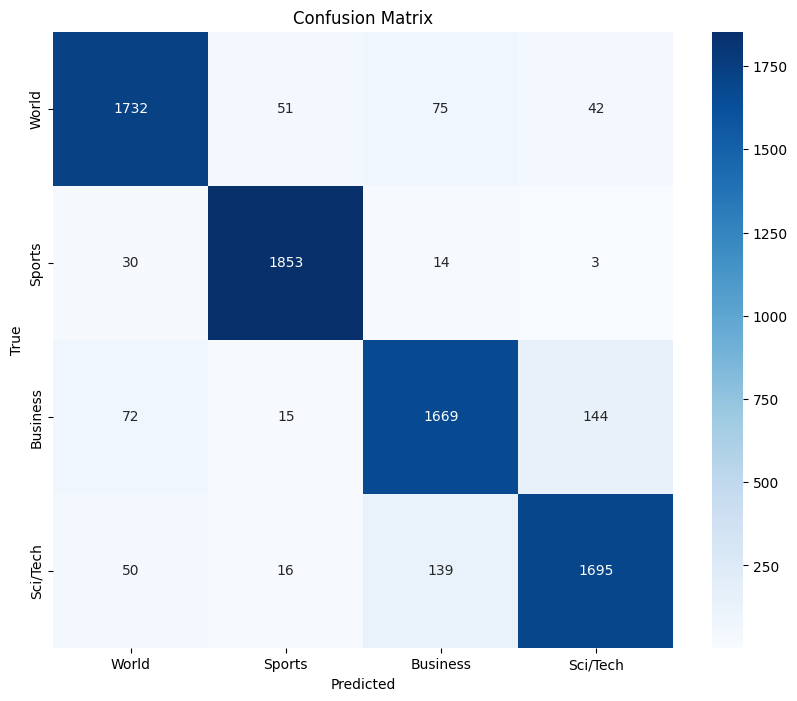

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())


    return all_labels, all_preds

y_true, y_pred = get_predictions(model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
